# MD Fakrul Islam, Certified Data Scientist, Machine Learning, Deep Learning Engineer and Big Data Professional
# Email: fakruldsebd@gmail.com
# Phone: +8801954345775
# https://www.linkedin.com/in/fakrul-islam-bd/
# https://github.com/aifakrul
# Contact for nlp/nlu, image, audio/speech, video processing and contextual ai in real time to solve your complex Business AI Problem



```
# **Batch Processing pipeline**
# How to manage your millions of datasets/images to process, make your hand dirty by TF records.  

```



## Imports

In [1]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: 
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE 

Tensorflow version 2.2.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#from google.colab import drive
#drive.flush_and_unmount()

## Configuration

In [4]:
GCS_PATTERN = '/content/drive/My Drive/Plant_Disease_Clinic/Tomato/*/*.JPG'
GCS_OUTPUT = '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [128, 128]
#CLASSES # do not change, maps to the labels in the data (folder names)
CLASSES = [b'Bacterial_Spot', b'Early_Blight', b'Healthy', b'Late_Blight', b'Leaf_Mold', b'Mosaic_Virus' , b'Septoria_Leaf_Spot', b'Target_Spot', b'Two_Spotted_Spider_Mite', b'Yellow_Leaf_Curl_Virus' ] # do not change, maps to the labels in the data (folder names)
print(CLASSES)

[b'Bacterial_Spot', b'Early_Blight', b'Healthy', b'Late_Blight', b'Leaf_Mold', b'Mosaic_Virus', b'Septoria_Leaf_Spot', b'Target_Spot', b'Two_Spotted_Spider_Mite', b'Yellow_Leaf_Curl_Virus']


In [5]:
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Read images and labels

In [6]:
print(GCS_PATTERN)
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
print(nb_images)
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print(shard_size)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  print(label)
  label = label.values[-2]
  print(label)
  return image, label

filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=10655) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)
print(shard_size)

/content/drive/My Drive/Plant_Disease_Clinic/Tomato/*/*.JPG
19828
1240
Pattern matches 19828 images which will be rewritten as 16 .tfrec files containing 1240 images each.
tf.RaggedTensor(values=Tensor("StringSplit/StringSplitV2:1", shape=(None,), dtype=string), row_splits=Tensor("StringSplit/RaggedFromValueRowIds/concat:0", shape=(None,), dtype=int64))
Tensor("strided_slice:0", shape=(), dtype=string)
1240


In [7]:
type(dataset1)
print(dataset1)

<ParallelMapDataset shapes: ((None, None, None), ()), types: (tf.uint8, tf.string)>


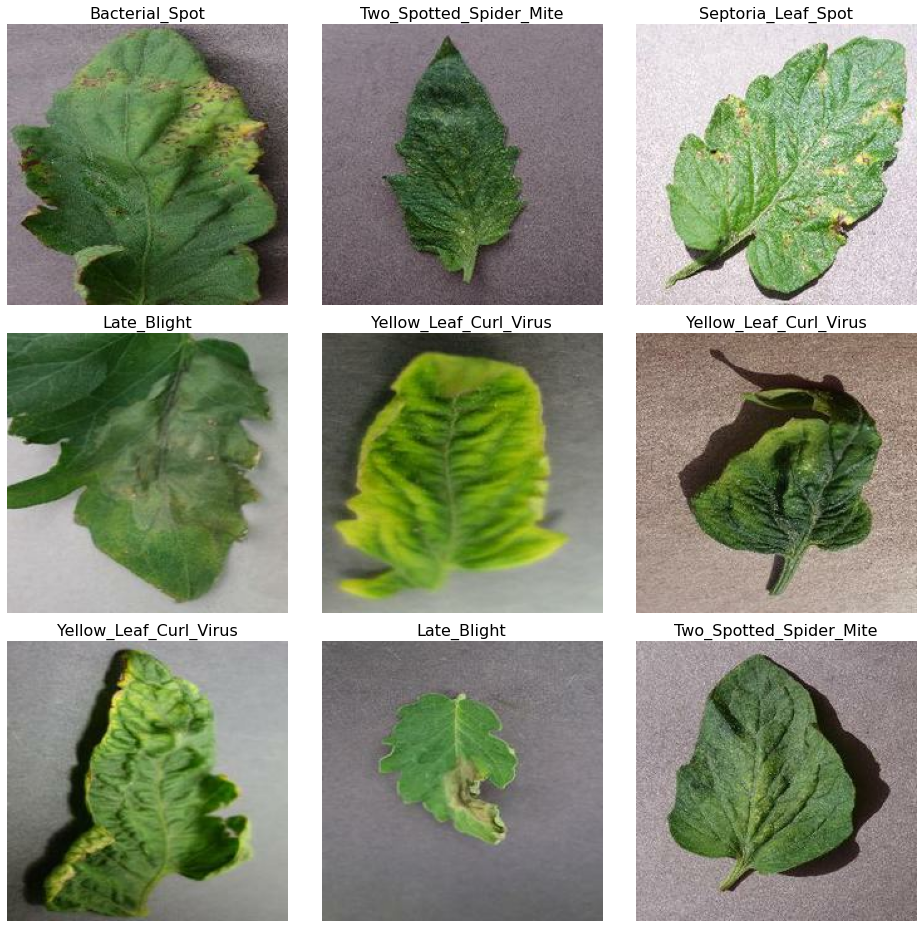

In [8]:
display_9_images_from_dataset(dataset1)

## Resize and crop images to common size
No need to study the code in this cell. It's only image resizing.

In [9]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

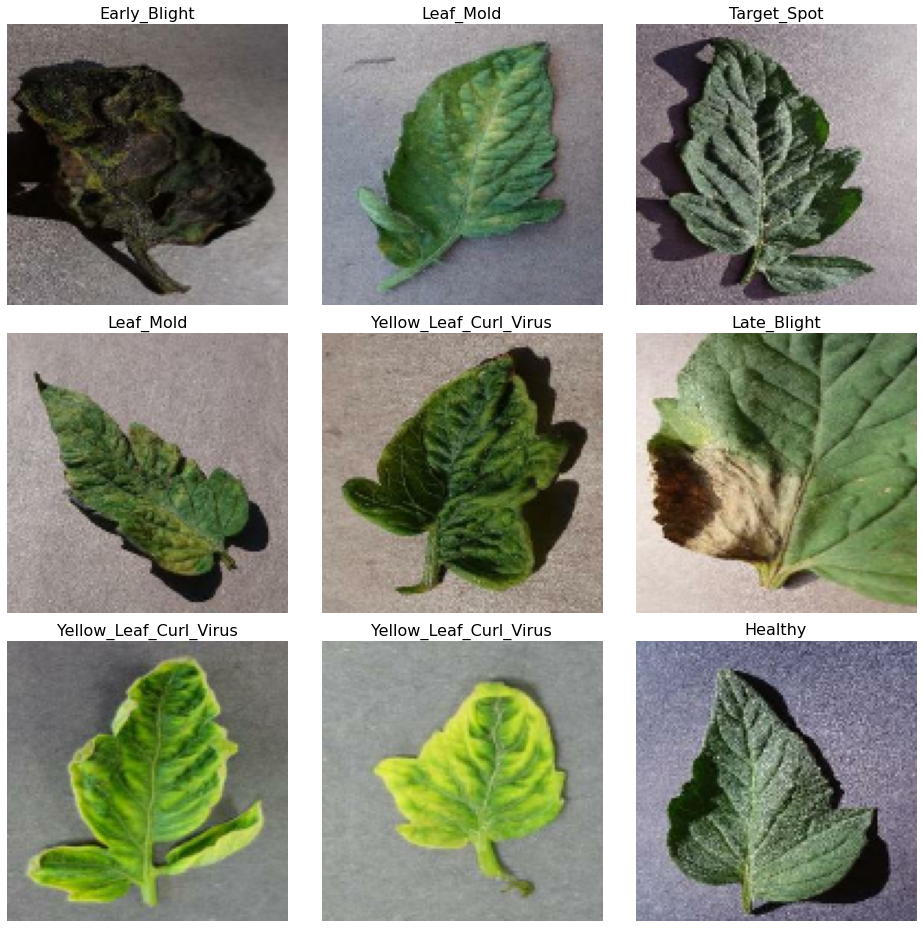

In [10]:
display_9_images_from_dataset(dataset2)

### Speed test-Slow: Training on thousands of individual files will not work. We have to use the **TFRecord** format to group files together. 

In [11]:
display_dataset = dataset2.batch(8)
for image, label in display_dataset.take(30):
  print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 128, 128, 3), ['Bacterial_Spot', 'Yellow_Leaf_Curl_Virus', 'Yellow_Leaf_Curl_Virus', 'Bacterial_Spot', 'Late_Blight', 'Late_Blight', 'Two_Spotted_Spider_Mite', 'Late_Blight'])
Image batch shape (8, 128, 128, 3), ['Yellow_Leaf_Curl_Virus', 'Target_Spot', 'Bacterial_Spot', 'Two_Spotted_Spider_Mite', 'Healthy', 'Bacterial_Spot', 'Target_Spot', 'Target_Spot'])
Image batch shape (8, 128, 128, 3), ['Target_Spot', 'Yellow_Leaf_Curl_Virus', 'Healthy', 'Two_Spotted_Spider_Mite', 'Mosaic_Virus', 'Bacterial_Spot', 'Yellow_Leaf_Curl_Virus', 'Yellow_Leaf_Curl_Virus'])
Image batch shape (8, 128, 128, 3), ['Yellow_Leaf_Curl_Virus', 'Bacterial_Spot', 'Bacterial_Spot', 'Healthy', 'Yellow_Leaf_Curl_Virus', 'Yellow_Leaf_Curl_Virus', 'Two_Spotted_Spider_Mite', 'Yellow_Leaf_Curl_Virus'])
Image batch shape (8, 128, 128, 3), ['Late_Blight', 'Bacterial_Spot', 'Early_Blight', 'Yellow_Leaf_Curl_Virus', 'Leaf_Mold', 'Yellow_Leaf_Curl_Virus', 'Yellow_Leaf_Curl_Virus', 'Healthy'])
Image batch

## Recompress the images for bandwidth savings by outweight the decoding CPU cost

In [12]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 
print(dataset3)

<BatchDataset shapes: ((None,), (None,), (None,), (None,)), types: (tf.string, tf.string, tf.int32, tf.int32)>


## Write dataset as TFRecord files

In [13]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num] # [0, 0, 1, 0, 0] for class #2

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()) # variable length  list of floats, n=len(CLASSES)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato00-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato01-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato02-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato03-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato04-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato05-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato06-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato07-1240.tfrec containing 1240 records
Wrote file /content/drive/My Drive/Plant_Disea

## Read  from TFRecord Dataset
**Resume running the cells**

In [14]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

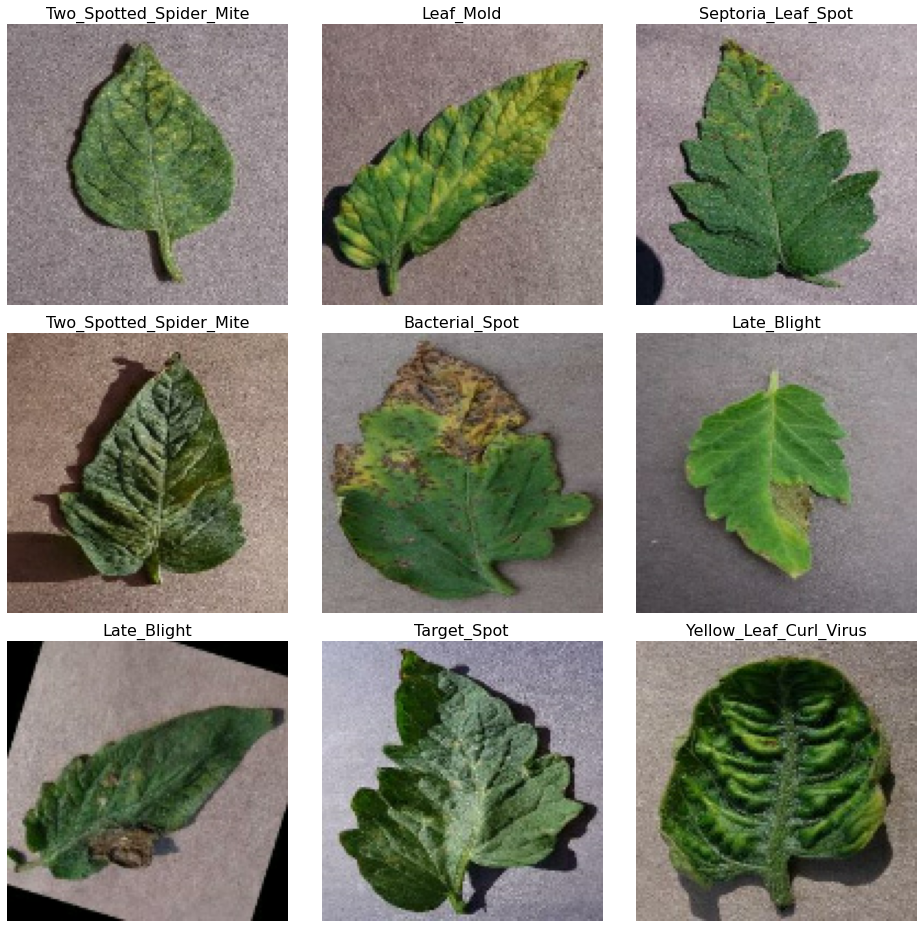

In [15]:
display_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))
display_9_images_from_dataset(display_dataset)

### Speed test: fast
Loading training data is not a bottleneck anymore

In [16]:
for image, class_num, label, height, width, one_hot_class in dataset4.take(300):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num, label.numpy().decode('utf8'), one_hot_class))

Image shape (128, 128, 3), 128x128 px, class=9 (Yellow_Leaf_Curl_Virus, [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.])
Image shape (128, 128, 3), 128x128 px, class=4 ( Leaf_Mold, [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.])
Image shape (128, 128, 3), 128x128 px, class=9 (Yellow_Leaf_Curl_Virus, [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.])
Image shape (128, 128, 3), 128x128 px, class=0 (Bacterial_Spot, [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
Image shape (128, 128, 3), 128x128 px, class=6 (Septoria_Leaf_Spot, [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.])
Image shape (128, 128, 3), 128x128 px, class=4 ( Leaf_Mold, [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.])
Image shape (128, 128, 3), 128x128 px, class=9 (Yellow_Leaf_Curl_Virus, [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.])
Image shape (128, 128, 3), 128x128 px, class=8 (Two_Spotted_Spider_Mite, [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.])
Image shape (128, 128, 3), 128x128 px, class=7 (Target_Spot, [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.])
Image shape (128, 128, 3), 128x128 px, class=2 (   Healthy, [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.])
Image sh